**Malaria Detection**

In [1]:
import numpy as np
% tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt



Load the Dataset

In [2]:
train_dataset,test_dataset  = tfds.load('Malaria', split=['train[:80%]', 'train[80%:]'], as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteKZB5ZE/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


Investigate the dataset

<dtype: 'uint8'>
0 image shape: (103, 103, 3)
<dtype: 'uint8'>
1 image shape: (106, 121, 3)
<dtype: 'uint8'>
2 image shape: (139, 142, 3)
<dtype: 'uint8'>
3 image shape: (130, 118, 3)
<dtype: 'uint8'>
4 image shape: (121, 109, 3)


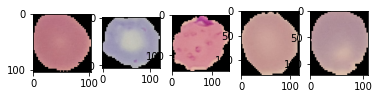

In [3]:

def printing_images(input_set):
  investigation_set = input_set.take(5)

  fig,ax = plt.subplots(1,5)
  counter = 0
  for (image, label) in investigation_set:
    print(image.dtype)
    print(counter, "image shape:", image.shape)
    ax[counter].imshow(image)
    counter +=1

printing_images(train_dataset)


  #have to adapt what we get out: diff loss, or diff accuracy calculation

**Preprocessing - Input Pipeline**

In [4]:
#train dataset

#padding (with zeros)
# we use the inbuild function to make all images the same size (120 x 120). Also, we convert the image to one-hot vectors with depth 2 because we have 2 labels.
train_dataset = train_dataset.map(lambda img,label: (tf.image.resize_with_pad(img, 120,120), tf.one_hot(label,2)))
#we map the values of image to values between 0 and 1 instead on 0-255
train_dataset = train_dataset.map(lambda img, label: (tf.math.divide(img,255),label))

#batching and prefetching
train_dataset_batched = train_dataset.batch(64)
train_dataset_shuffled = train_dataset_batched.shuffle(64)
training_data = train_dataset_batched.prefetch(20)

#test dataset
test_dataset = test_dataset.map(lambda img,label: (tf.image.resize_with_pad(img, 120,120), tf.one_hot(label,2)))
test_dataset = test_dataset.map(lambda img, label: (tf.math.divide(img,255),label))

test_dataset_batched = test_dataset.batch(64)
test_dataset_shuffled = test_dataset_batched.shuffle(64)
test_data = test_dataset_batched.prefetch(20)

**Build the model**

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model):
  def __init__(self):
    super(Model,self).__init__()

    #Define the layers of the model: feature extraction
    self.conv_1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, 
                                         padding = 'valid', activation = tf.keras.activations.relu,
                                         input_shape = (120,120))
    
    self.pool_1 = tf.keras.layers.MaxPool2D()

    self.conv_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, 
                                         padding = 'valid', activation = tf.keras.activations.relu)
    
    self.pool_2 = tf.keras.layers.MaxPool2D()

    self.conv_3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, 
                                         padding = 'valid', activation = tf.keras.activations.relu)
    
    self.pool_3 = tf.keras.layers.MaxPool2D()

    self.conv_4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, 
                                         padding = 'valid', activation = tf.keras.activations.relu)
    
    #transform to vector that can be fed to classification
    self.averagePool = tf.keras.layers.GlobalAveragePooling2D()

    
    #Classification: using simple MLP with no hidden layer --> just the output layer
    self.output_layer = tf.keras.layers.Dense(2, activation = tf.keras.activations.softmax)

  def call(self, x):
    x = self.conv_1(x)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = self.pool_2(x)
    x = self.conv_3(x)
    x = self.pool_3(x)
    x = self.conv_4(x)
    x = self.averagePool(x)
    x = self.output_layer(x)

    return x


**Training**

In [6]:
'''Training step
  args: model, input (batch of data), target(batch of correct labels), loss_function, optimizer (how to perform the updates)'''
def train_step(model, input, target, loss_function, optimizer):
  
  #For each batch we compute loss and accuracy based on the models prediction
  with tf.GradientTape() as tape:
    prediction = model(input)

    loss = loss_function(prediction, target)
        
    accuracy = np.sum(np.argmax(target, axis=1) == np.argmax(prediction, axis=1)) / target.shape[0]
    
    #we compute the gradient of the loss with respect to the parameters
    gradients = tape.gradient(loss, model.trainable_variables)
  
  #update the parameters on the basis of the computed gradients
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, accuracy


Testing


In [7]:
'''Test step:
  args: the model, test_data as input and the loss_function'''
def test(model, input, loss_function):
  #iterate over the test_data and evaluate the models performance
  for(image,label) in input:
    #prediction of the model for the current samples
    prediction = model(image)

    test_losses = []
    test_accuracies = []

    #calculate the loss and accuracy
    loss = loss_function(prediction, label)
    accuracy = (np.argmax(prediction, axis=1) == np.argmax(label, axis = 1))

    test_losses.append(loss.numpy())
    test_accuracies.append(np.mean(accuracy))
  
  #return the mean of the performance data: loss and accuracy
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)

  return test_loss, test_accuracy

**Perform the Training and TEsting**


In [8]:
tf.keras.backend.clear_session()

#Initialize model
model = Model()

#hyperparameters
epochs = 15
learning_rate = 0.0001 

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

running_average_factor = 0.95

#To keep track of the processes, we use several lists
training_steps = []

train_losses= []
train_accuracies = []

test_losses = []
test_accuracies = []

#test once before training the model
test_loss, test_accuracy = test(model, test_data, loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#how does the model do on training data before training?
train_loss, train_accuracy = test(model, training_data, loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

#now start to train
#run through the training_data_set in one epoch and adapt parameters (batchwise)
#repeta for number of epochs
for epoch in range(epochs):
  print( "---------------------------------------- Epoch Number:", epoch)

  training_steps.append(epoch)
  #run through the current batch

  training_data = training_data.shuffle(buffer_size=64)
  test_data = test_data.shuffle(buffer_size=64)

  running_average_loss = 0
  running_average_accuracy = 0

  #with a for loop we iterate over all the batches in the datset
  #for each batch in the dataset: peform the training_step and update the parameters based on the computed loss for the whole batch
  for i,(input, label) in enumerate(training_data):
    #to keep track of our models progress we save training loss and accuracy
    training_loss, training_accuracy = train_step(model, input, label, loss, optimizer)

    #however with one 172 batches (thus accuracies and losses) the graph would look quite messy, thus we update our loss and accuracy in a weighted manner
    #after each batch (update is weighted by the running_average_factor)
    running_average_accuracy = running_average_factor * running_average_accuracy + (1- running_average_factor) * training_accuracy
    running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * training_loss 

  #After completing all the batches we append the computed loss and accuracy to the list
  train_losses.append(running_average_loss)
  train_accuracies.append(running_average_accuracy)

  #now evaluate the models performance on test set
  test_loss, test_accur = test(model, test_data, loss)
  
  test_losses.append(test_loss)
  test_accuracies.append(test_accur)

  #print current performance data
  print(i, 'number of test_steps performed: each with 64 examples, so:', 64*i)
  print('training_loss: ', running_average_loss.numpy(), 'training_accuracy: ', train_accuracies[epoch])
  print('test_loss: ', test_loss, 'test_accuracy: ', test_accur)


---------------------------------------- Epoch Number: 0
344 number of test_steps performed: each with 64 examples, so: 22016
training_loss:  5.4136477 training_accuracy:  0.43333333333333335
test_loss:  5.9273267 test_accuracy:  0.625
---------------------------------------- Epoch Number: 1
344 number of test_steps performed: each with 64 examples, so: 22016
training_loss:  4.7273 training_accuracy:  0.6602272268514123
test_loss:  5.6467886 test_accuracy:  0.609375
---------------------------------------- Epoch Number: 2
344 number of test_steps performed: each with 64 examples, so: 22016
training_loss:  2.9070315 training_accuracy:  0.719455004262562
test_loss:  2.8514583 test_accuracy:  0.828125
---------------------------------------- Epoch Number: 3
344 number of test_steps performed: each with 64 examples, so: 22016
training_loss:  2.0629742 training_accuracy:  0.8426283787516264
test_loss:  1.9787366 test_accuracy:  0.890625
---------------------------------------- Epoch Number:

**Visualization**

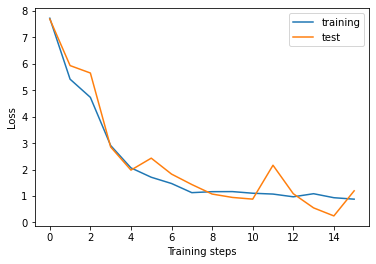

In [9]:
import matplotlib.pyplot as plt

#do the visualization
#test loss and training loss
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

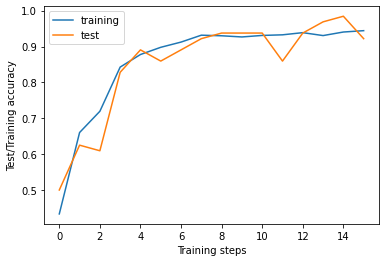

In [10]:
#test accuracy and training accuracy
plt.figure()
line1, = plt.plot(train_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Test/Training accuracy")
plt.legend((line1,line2),("training","test"))
plt.show()

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  36928 